# Modelo + Avaliação + Conclusões

---

Alunos:

- Caio Cardoso
- Adson Leal
- Diego Marzarotto

---

## Proposta

---

- serão treinados 3 modelos com número distintos de atributos
- o primeiro modelo utiliza um conjunto reduzido de features (107)
- o segundo modelo utiliza um conjunto com um número intermediário de features (541)
- o terceiro modelo utiliza um conjunto com um número maior de features (1153)
- conjuntos de dados formado por 40311 exemplos
- exemplos separados em 3 conjuntos distintos (treinamento, validação e teste)
- conjunto de dados separado na proporção 80/20 em treinamento e testes
- conjunto de treinamento separado na proporção 80/20 em treinamento e validação
- modelos formados por um comitê de modelos
- hiperparâmetros selecionados de acordo com acurácia no conjunto de validação
- modelo com melhor resultado no conjunto de validação será o modelo escolhido

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import  MultinomialNB, BernoulliNB

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

%matplotlib inline

SEED = 33

In [2]:
def select_model(model, 
                 model_name, 
                 X_train, 
                 y_train, 
                 X_val, 
                 y_val, 
                 grid, 
                 verbose=False):
    
    print "=========================================="
    print "Modelo: %s" % model_name
    print "=========================================="
    best_score = 0
    for p in ParameterGrid(grid):
        model.set_params(**p)
        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        if verbose:
            print score, p
            print "-------------------------------------------"

        if score > best_score:
            best_score = score
            best_params = p
 
    print ''
    if verbose: print "Modelo: %s" % model_name 
    print "Acurácia (val): %0.5f\n" % best_score 
    print best_params, '\n'
    
    return model, best_params, best_score

In [3]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Inferida')

In [4]:
def create_ensemble(models, X_train, y_train, X_val, y_val):
    estimators, accuracies = [], []
    for (model_name, model, grid) in models:
        best_model, _, best_score = select_model(model, 
                                                 model_name, 
                                                 X_train, 
                                                 y_train, 
                                                 X_val, 
                                                 y_val, 
                                                 grid)
        
        estimators.append((model_name, best_model))
        accuracies.append((model_name, best_score))
        
    best_models = dict(sorted(accuracies, key=lambda x: x[1], reverse=True)[:5])
    estimators = filter(lambda m : m[0] in best_models, estimators)
    
    return VotingClassifier(estimators=estimators, voting='hard'), accuracies

In [5]:
def train_and_evaluate_ensemble(models, 
                                features_filepath, 
                                labels_filepath='./labels.csv'):
    
    features = pd.read_csv(features_filepath)
    labels = pd.read_csv(labels_filepath)

    X = features.values
    y = labels.desfecho.values.reshape(-1,)

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=SEED)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size=0.2, 
                                                      random_state=SEED)

    ensemble, accuracies = create_ensemble(models, X_train, y_train, X_val, y_val)
    ensemble.fit(X_train, y_train)
    
    print "=========================================="
    print 'Ensemble'
    print "==========================================\n"
    print 'Acurácia (val): ', ensemble.score(X_val, y_val)
    print 'Acurácia (test): ', ensemble.score(X_test, y_test)
    
    classes = labels.drop_duplicates().sort_values('desfecho').classes.values
    
    cnf = confusion_matrix(y_test, ensemble.predict(X_test))
    
    plot_confusion_matrix(cnf, 
                          classes=classes, 
                          title='Matriz de Confusão (test)')
    
    plot_confusion_matrix(cnf, 
                          classes=classes, 
                          normalize=True, 
                          title='Matriz de Confusão Normalizada (test)')
    
    return ensemble, accuracies

In [6]:
models = [
    
    ('naive bayes (multinomial)', MultinomialNB(),  [{ 
        'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1]
    }]),
    
    ('naive bayes (binomial)', BernoulliNB(), [{ 
        'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1]
    }]),
    
    ('random forest', RandomForestClassifier(random_state=SEED), [{
        'n_estimators': [1, 2, 3, 4], 
        'max_depth': [2, 5, 10, 25, 50],
        "min_samples_split": [2, 5, 10, 25, 50]
    }]),
        
    ('árvore de decisão (cart)', DecisionTreeClassifier(random_state=SEED), [{
        'criterion': ['gini', 'entropy'],
        "min_samples_split": [2, 5, 10, 25, 50],
        "max_depth": [None, 2, 5, 10, 25, 50],
        "min_samples_leaf": [2, 5, 10, 25, 50],
        "max_leaf_nodes": [None, 5, 10, 25, 50]
    }]),
    
    ('gradient boosted tree', GradientBoostingClassifier(random_state=SEED), [{
        'n_estimators': [1, 2, 3, 4], 
        'learning_rate': [0.1, 0.3, 0.5],
        'max_depth': [2, 5, 10, 25, 50],
    }]),
    
    ('regressão logística', SGDClassifier(random_state=SEED), [{ 
        'loss': ['log'],
        'penalty': ['l2',],
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.01, 0.1],
        'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.01, 0.1],
    }]),
    
    ('svm (linear)', LinearSVC(random_state=SEED) ,[{
        'loss': ['hinge', 'squared_hinge'], 
        'multi_class': ['ovr'],
        "penalty": ['l2'],
        'C': [0.01, 0.1, 1, 10, 100, 1000]
    }]),
    
    ('svm (kernel)', SVC(random_state=SEED), [
        {
            'kernel': ['poly'], 
            'C': [0.01, 0.1, 1, 10, 100, 1000], 
            'decision_function_shape' : ['ovr'], 
            'degree' : [2, 3, 4, 5]
        },
        {
            'kernel': ['rbf'], 
            'C': [0.01, 0.1, 1, 10, 100, 1000], 
            'decision_function_shape' : ['ovr']
        }
    ])
    
]

## Modelo 1 (número reduzido de features)

---

Modelo: naive bayes (multinomial)

Acurácia (val): 0.74682

{'alpha': 0.99} 

Modelo: naive bayes (binomial)

Acurácia (val): 0.74264

{'alpha': 0.99} 

Modelo: random forest

Acurácia (val): 0.77907

{'min_samples_split': 10, 'n_estimators': 4, 'max_depth': 10} 

Modelo: árvore de decisão (cart)

Acurácia (val): 0.78279

{'min_samples_split': 2, 'max_leaf_nodes': 50, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 25} 

Modelo: gradient boosted tree

Acurácia (val): 0.78109

{'n_estimators': 3, 'learning_rate': 0.3, 'max_depth': 2} 

Modelo: regressão logística

Acurácia (val): 0.77783

{'penalty': 'l2', 'alpha': 0.001, 'eta0': 1e-05, 'loss': 'log'} 

Modelo: svm (linear)

Acurácia (val): 0.78295

{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.1, 'multi_class': 'ovr'} 

Modelo: svm (kernel)

Acurácia (val): 0.78186

{'kernel': 'poly', 'C': 100, 'decision_function_shape': 'ovr', 'degree': 2} 

Ensemble

Acurácia (val):  0.781395348837
Acurácia (test):  0.779114473521


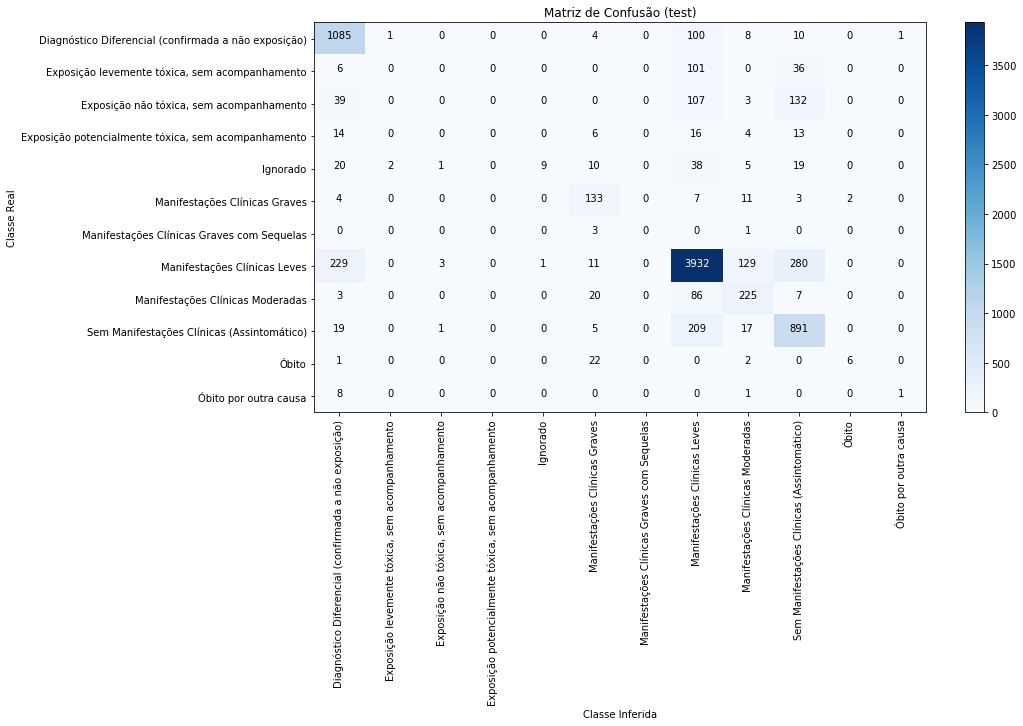

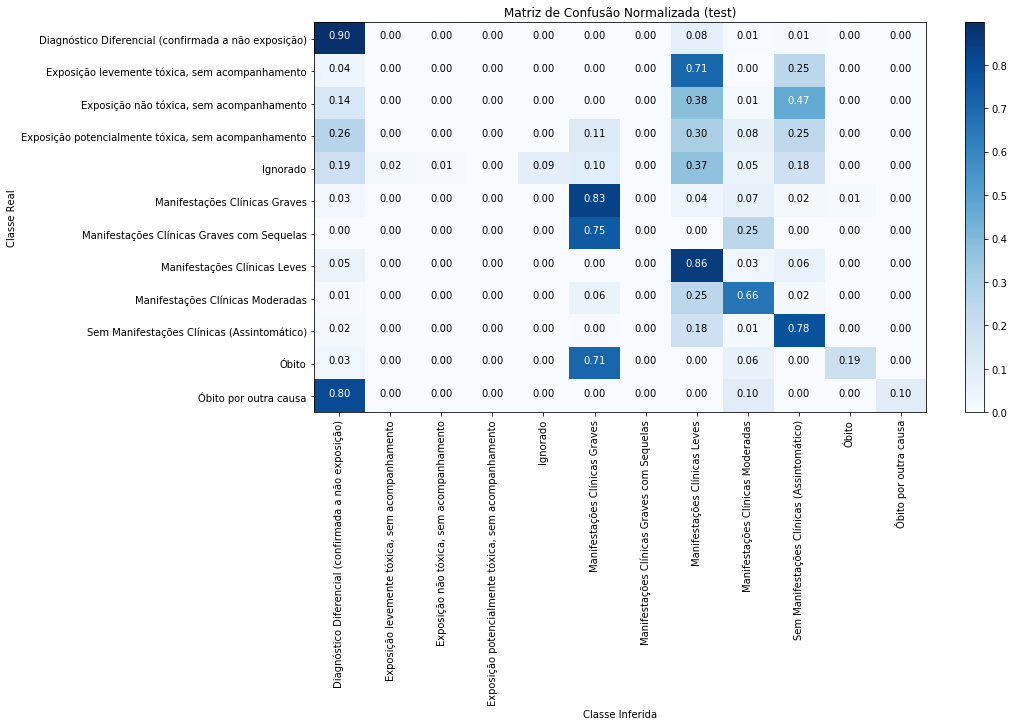

In [7]:
ensemble1, accuracies1 = train_and_evaluate_ensemble(models, 
                                                     './features1.csv', 
                                                     './labels.csv')

## Modelo 2:  (número intermediário de features)

---

Modelo: naive bayes (multinomial)

Acurácia (val): 0.70450

{'alpha': 0.999} 

Modelo: naive bayes (binomial)

Acurácia (val): 0.70031

{'alpha': 0.99} 

Modelo: random forest

Acurácia (val): 0.77721

{'min_samples_split': 25, 'n_estimators': 4, 'max_depth': 25} 

Modelo: árvore de decisão (cart)

Acurácia (val): 0.78326

{'min_samples_split': 50, 'max_leaf_nodes': 50, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10} 

Modelo: gradient boosted tree


/home/ccc/workspace/tools/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:583: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/home/ccc/workspace/tools/anaconda2/lib/python2.7/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/home/ccc/workspace/tools/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:558: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-1 * sample_weight * (Y * pred).sum(axis=1) +



Acurácia (val): 0.78310

{'n_estimators': 3, 'learning_rate': 0.3, 'max_depth': 2} 

Modelo: regressão logística

Acurácia (val): 0.77845

{'penalty': 'l2', 'alpha': 0.001, 'eta0': 1e-05, 'loss': 'log'} 

Modelo: svm (linear)

Acurácia (val): 0.78419

{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.01, 'multi_class': 'ovr'} 

Modelo: svm (kernel)

Acurácia (val): 0.78326

{'kernel': 'rbf', 'C': 10, 'decision_function_shape': 'ovr'} 

Ensemble

Acurácia (val):  0.774728682171
Acurácia (test):  0.777502170408


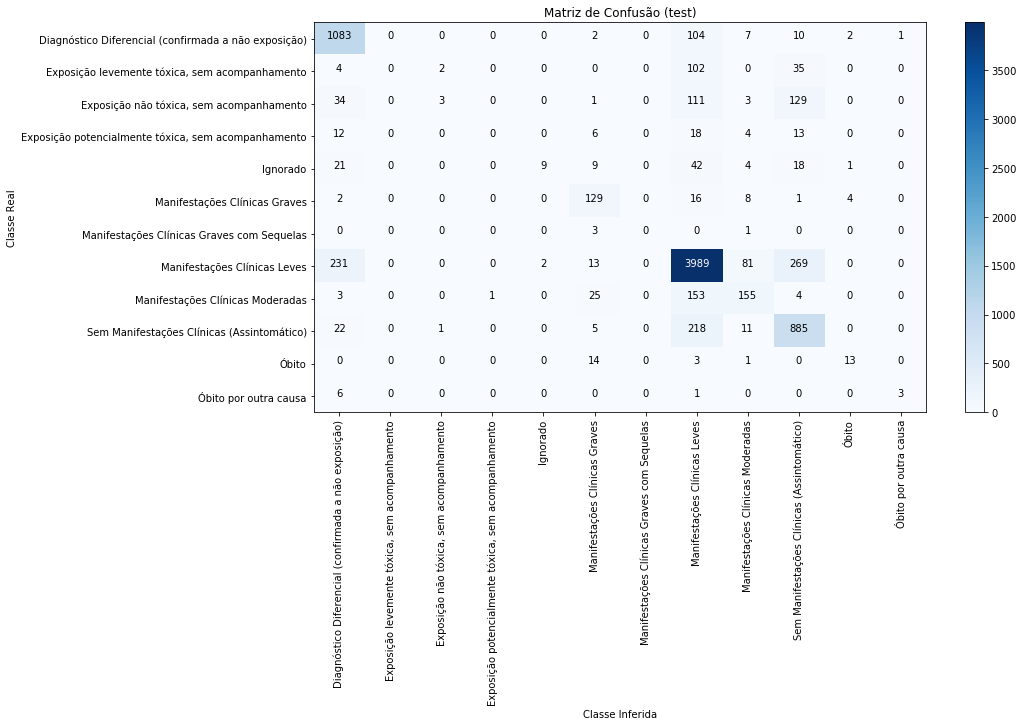

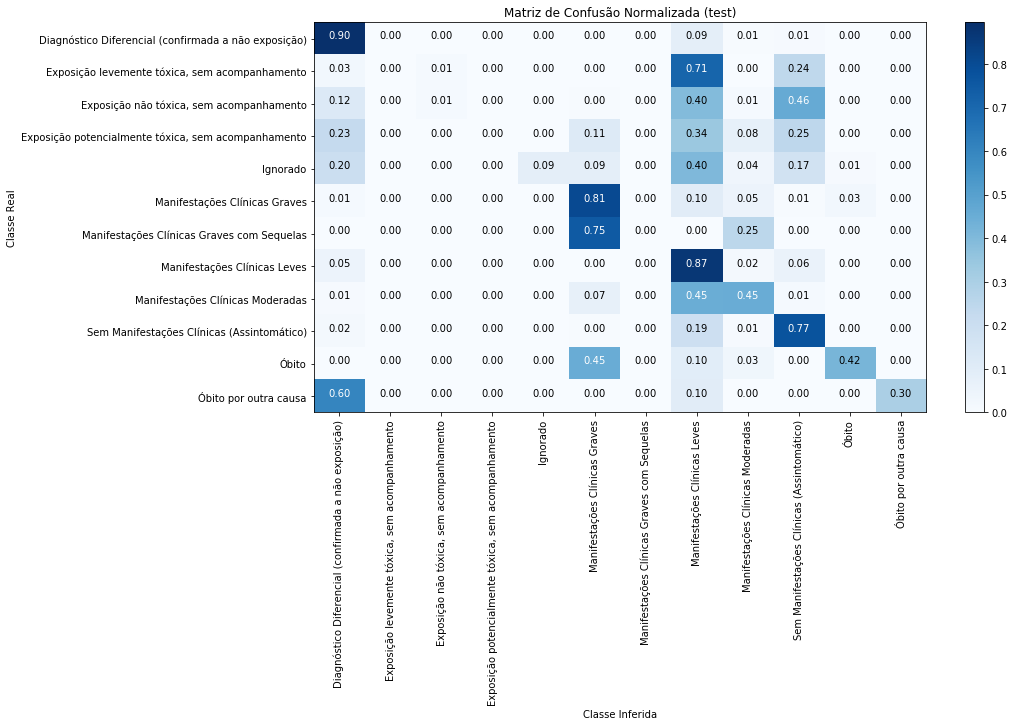

In [8]:
ensemble2, accuracies2 = train_and_evaluate_ensemble(models, 
                                                     './features2.csv', 
                                                     './labels.csv')

## Modelo 3:  (número ampliado de features)

---

Modelo: naive bayes (multinomial)

Acurácia (val): 0.69240

{'alpha': 0.99} 

Modelo: naive bayes (binomial)

Acurácia (val): 0.69178

{'alpha': 0.999} 

Modelo: random forest

Acurácia (val): 0.76698

{'min_samples_split': 50, 'n_estimators': 4, 'max_depth': 50} 

Modelo: árvore de decisão (cart)

Acurácia (val): 0.78295

{'min_samples_split': 50, 'max_leaf_nodes': 50, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2} 

Modelo: gradient boosted tree

Acurácia (val): 0.78310

{'n_estimators': 3, 'learning_rate': 0.3, 'max_depth': 2} 

Modelo: regressão logística

Acurácia (val): 0.78062

{'penalty': 'l2', 'alpha': 0.001, 'eta0': 1e-05, 'loss': 'log'} 

Modelo: svm (linear)

Acurácia (val): 0.78434

{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.1, 'multi_class': 'ovr'} 

Modelo: svm (kernel)

Acurácia (val): 0.78248

{'kernel': 'poly', 'C': 1000, 'decision_function_shape': 'ovr', 'degree': 2} 

Ensemble

Acurácia (val):  0.775813953488
Acurácia (test):  0.779362520154


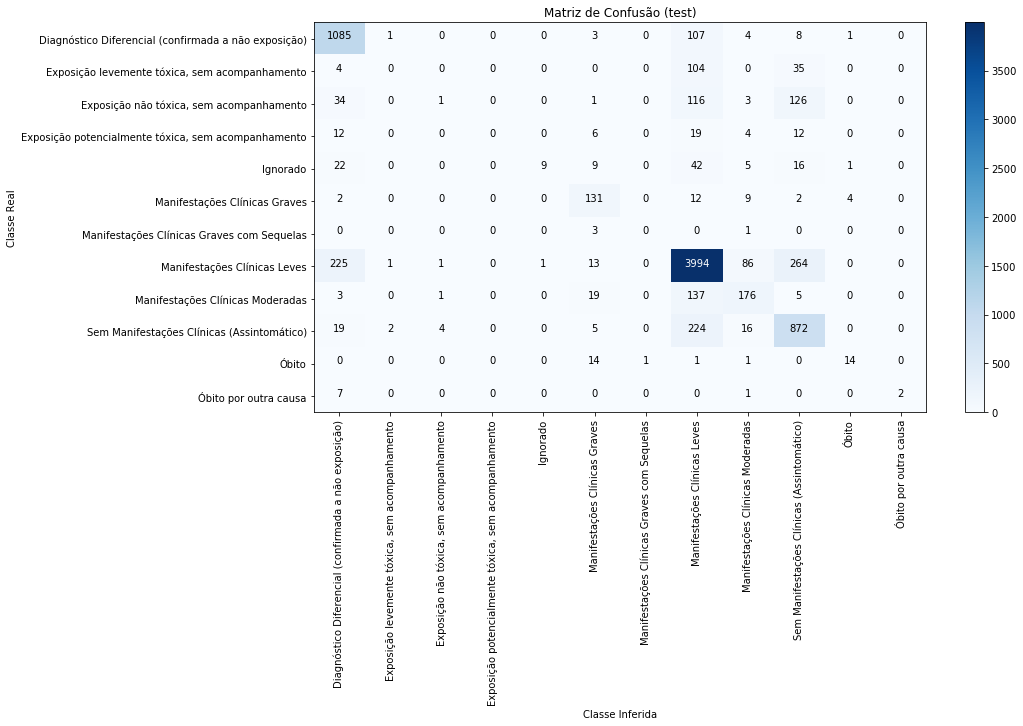

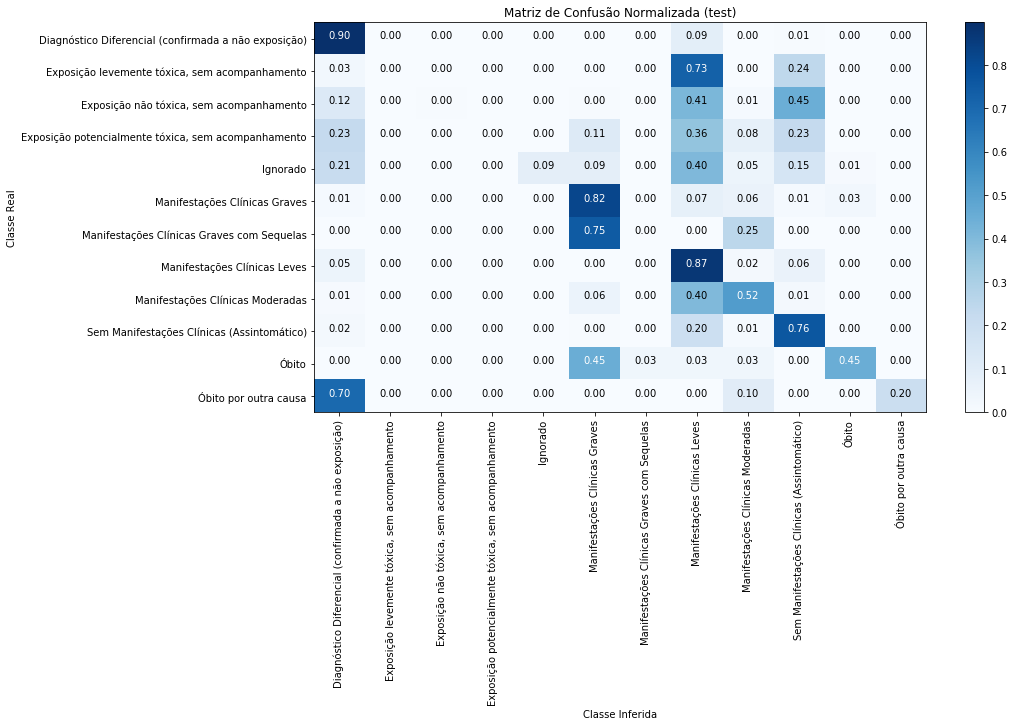

In [9]:
ensemble3, accuracies3 = train_and_evaluate_ensemble(models, 
                                                     './features3.csv', 
                                                     './labels.csv')

## Resultados

In [42]:
pd.DataFrame(accuracies1).sort_values(1, ascending=False)

,0,1
6,svm (linear),0.782946
3,árvore de decisão (cart),0.782791
7,svm (kernel),0.781860
4,gradient boosted tree,0.781085
2,random forest,0.779070
5,regressão logística,0.777829
0,naive bayes (multinomial),0.746822
1,naive bayes (binomial),0.742636


In [41]:
pd.DataFrame(accuracies2).sort_values(1, ascending=False)

,0,1
6,svm (linear),0.784186
3,árvore de decisão (cart),0.783256
7,svm (kernel),0.783256
4,gradient boosted tree,0.783101
5,regressão logística,0.778450
2,random forest,0.777209
0,naive bayes (multinomial),0.704496
1,naive bayes (binomial),0.700310


In [40]:
pd.DataFrame(accuracies3).sort_values(1, ascending=False)

,0,1
6,svm (linear),0.784341
4,gradient boosted tree,0.783101
3,árvore de decisão (cart),0.782946
7,svm (kernel),0.782481
5,regressão logística,0.780620
2,random forest,0.766977
0,naive bayes (multinomial),0.692403
1,naive bayes (binomial),0.691783


In [10]:
features = pd.read_csv('features3.csv')
labels = pd.read_csv('labels.csv')

X = features.values
y = labels.desfecho.values.reshape(-1,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

hyperparameters = {'penalty': 'l2', 'loss': 'squared_hinge', 'C': 0.1, 'multi_class': 'ovr'} 
clf = LinearSVC(**hyperparameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.78308321964529326

## Conclusões

---

- Modelos mais simples pioraram com um número maior de atributos
- Modelos mais complexos melhoraram com um número maior de atributos
- Comitê teve um desempenho pior que alguns modelos sozinhos
- Melhor modelo: 0.78308 acurácia no conjunto de testes  (svm linear + conjunto #3)
- Modelo 1: 0.77911 acurácia no conjunto de testes (comitê)
- Modelo 2:.7775 acurácia no conjunto de testes (comitê)
- Modelo 3: 0.77936 acurácia no conjunto de testes (comitê)
- knn foi utilizado inicialmente, removido posteriormente pela lentidão

## Possibilidades de melhoria


---

- experimentar outras abordagens para codificar atributos contínuos (peso, idade)
- identificar atributos relevantes através de algum algoritmo de seleção de atributos (regressão lasso)
- gerar um modelo utilizando somente atributos mais relevantes para a classificação
- incluir outros modelos de classificação no comitê (redes neurais)
- utilizar pesos baseados na performance de cada modelo na classificação final do comitê
- agrupar classes de acordo com um melhor entendimento do domínio
- avaliar performance dos modelos utilizando métrica f1, mas indicada para classes desbalanceadas
- continuar busca de hiperparâmetros 